In [1]:
import sys
from torchsummary import summary
import ast
import torch
import random
import numpy as np
import icecream as ic
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
sys.path.append("../../")
sys.path.append("../")
####### Dataset ############
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug
from sklearn.metrics import accuracy_score
import torch.multiprocessing as mp

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
def load_dataset_metadata(dataset_path):
    with open(os.path.join(dataset_path, 'metadata'), "r") as f:
        metadata = json.load(f)
    return metadata
# load dataset from file
def load_datasets(data_path, truncate):
    data_path = '../../datasets/'+data_path
    train_x = np.load(os.path.join(data_path,'train_x.npy'))
    train_y = np.load(os.path.join(data_path,'train_y.npy'))
    valid_x = np.load(os.path.join(data_path,'valid_x.npy'))
    valid_y = np.load(os.path.join(data_path,'valid_y.npy'))
    test_x = np.load(os.path.join(data_path,'test_x.npy'))
    metadata = load_dataset_metadata(data_path)

    if truncate:
        train_x = train_x[:64]
        train_y = train_y[:64]
        valid_x = valid_x[:64]
        valid_y = valid_y[:64]
        test_x = test_x[:64]

    return (train_x, train_y), \
           (valid_x, valid_y), \
           (test_x), metadata

def validation(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 4. Calculate Accuracy
    accuracy = correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy * 100))

In [3]:
Dataset="AddNIST"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../../datasets/'+Dataset,'test_y.npy'))
metadata["select_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


metadata

/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


{'num_classes': 20,
 'input_shape': [50000, 3, 28, 28],
 'codename': 'Adaline',
 'benchmark': 89.85,
 'select_augment': False,
 'train_config_path': 'anki_lab_submission/configs/train/augmentations_adam.yaml'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


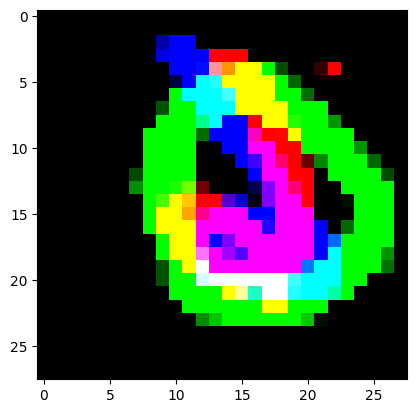

In [4]:
img=next(iter(train_loader))[0][0]
img=img.numpy().transpose(1, 2, 0)
plt.imshow(img)

# Load search space and population

In [5]:
rg=regnet_space=RegNet(metadata,
                    W0=[16, 120, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config=f"../configs/search_space/config.yaml")

In [3]:
#model_best, info_best, _= regnet.load_model("output/test_regnet_cifar100/RegNetY800MF", weights_file="output/test_regnet_cifar100/RegNetY800MF/student_best")
#summary(model_best, (3,32,32))

In [6]:
import gc
gc.collect()

97

In [7]:
    current_time=datetime.now().strftime("%d_%m_%Y_%H_%M")
    test_folder=f"{os.getenv('WORK')}/NAS_COMPETITION_RESULTS/kwnowledge_distillation/kd/{current_time}/{metadata['codename']}"
    
    folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}"
    models, chromosomes=rg.load_generation(folder)
    #models, chromosomes=rg.create_random_generation(save_folder=test_folder,gen=None, size=1, config_updates=None)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/emerald_aardwark/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/onyx_gaur/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/rampant_myna/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/succinct_chimpanzee/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/red_caterpillar/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/thistle_owl/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/mahogany_collie/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Adaline/quizzical_caiman/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULT

# Knowledge inheritance

In [9]:
from torchinfo import summary

In [38]:
summary(models["abiding_markhor"], input_size=next(iter(train_loader))[0].shape[:])

Layer (type:depth-idx)                             Output Shape              Param #
RegNet                                             [128, 20]                 --
├─ResStemCifar: 1-1                                [128, 28, 28, 28]         --
│    └─Conv2d: 2-1                                 [128, 28, 28, 28]         756
│    └─BatchNorm2d: 2-2                            [128, 28, 28, 28]         56
│    └─ReLU: 2-3                                   [128, 28, 28, 28]         --
├─AnyStage: 1-2                                    [128, 64, 14, 14]         --
│    └─ResBottleneckBlock: 2-4                     [128, 64, 14, 14]         --
│    │    └─BottleneckTransform: 3-1               [128, 64, 14, 14]         11,847
│    │    └─DropPath: 3-2                          [128, 64, 14, 14]         --
│    │    └─Sequential: 3-3                        [128, 64, 14, 14]         1,920
│    │    └─ReLU: 3-4                              [128, 64, 14, 14]         --
├─AnyStage: 1-3            

In [24]:
chromosomes[list(chromosomes.keys())[1]]

{'ws': [96, 200, 400, 824],
 'bs': [1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8],
 'ds': [2, 4, 10, 3],
 'num_stages': 4,
 'total_size_mb': 37.75217819213867,
 'h': 1,
 'w': 1,
 'flops': 1704959,
 'params': 9896507,
 'acts': 9151,
 'WA': 32.0,
 'W0': 96,
 'WM': 2.05,
 'DEPTH': 19,
 'GROUP_W': 8}

In [7]:
from utils.train_cfg import load_checkpoint
keys_to_delete=[]
super_model={}
for model_name, model in models.items():
    try:
        weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata["codename"]}/{model_name}/student_best"
        state = load_checkpoint(weights_file)
        model.load_state_dict(state["model"])
    except:
        # Collect the keys that need to be deleted
        keys_to_delete.append(model_name)
# Remove the collected keys from both dictionaries
for key in keys_to_delete:
    del models[key]
    del chromosomes[key]

In [8]:
len(models.keys())

118

In [59]:
model=models[model_name]
stage=2
attribute_chain = f"model.s2.b1.state_dict"



In [8]:
def get_state_dict(attribute_chain):
        # Split the attribute chain into parts
        attrs = attribute_chain.split('.')
        # Start with the model object
        current_obj = eval(attrs.pop(0))  # eval is used only to get 'model', this part is safe
        # Iterate through the attribute chain
        for attr in attrs:
            current_obj = getattr(current_obj, attr)
        # If the final attribute is callable (e.g., a method), call it
        if callable(current_obj):
            result = current_obj()
        else:
            result = current_obj
        return result

In [61]:
get_state_dict(attribute_chain)

OrderedDict([('f.a.weight',
              tensor([[[[-0.0670]],
              
                       [[-0.0040]],
              
                       [[ 0.0527]],
              
                       ...,
              
                       [[-0.0299]],
              
                       [[-0.0517]],
              
                       [[ 0.0660]]],
              
              
                      [[[ 0.0058]],
              
                       [[ 0.0004]],
              
                       [[-0.0177]],
              
                       ...,
              
                       [[-0.1535]],
              
                       [[ 0.0154]],
              
                       [[ 0.0358]]],
              
              
                      [[[ 0.0073]],
              
                       [[ 0.0054]],
              
                       [[ 0.0563]],
              
                       ...,
              
                       [[-0.0336]],
          

In [10]:
import itertools
#for model_name, chrom in itertools.islice(chromosomes.items(), 4):
for model_name, chrom in chromosomes.items():
    model=models[model_name]
    for stage, ws in enumerate(chrom["ws"], start=1): 
        if chrom["ds"][stage-1]>1:
            main_block_name=f"{ws}"
            if main_block_name not in super_model:
                main_block_index=f"model.s{stage}.b2.state_dict"
                super_model[main_block_name]=get_state_dict(main_block_index)
        if stage>1:
            transition_block_name=f"{chrom["ws"][stage-2]}-{ws}"
            if transition_block_name not in super_model:
                block_index=f"model.s{stage}.b1.state_dict"
                super_model[transition_block_name]=get_state_dict(block_index)
            

                


In [9]:
from utils.train_cfg import save_checkpoint, load_checkpoint
#save_checkpoint(super_model, f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/blocks_pool/{metadata["codename"]}_super_model")
super_models=[]
for codename in ["Adaline", "Caitie","Chester","Gutenberg","LaMelo","Mateo", "Sadie"]:
    if metadata["codename"]!=codename:
        print(codename)
        super_models.append(load_checkpoint(f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/blocks_pool/{codename}_super_model"))
        


# Merging process
blocks_pool = {}  # Start with dict1

for d in super_models:
    for key, value in d.items():
        if key not in blocks_pool:
            blocks_pool[key] = value

Caitie
Chester
Gutenberg
LaMelo
Mateo
Sadie


In [19]:
len(super_models[4].keys())

294

In [18]:
chromosomes[list(chromosomes.keys())[2]]

{'ws': [64, 168, 448, 1192],
 'bs': [1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8],
 'ds': [1, 3, 8, 7],
 'num_stages': 4,
 'total_size_mb': 111.36352920532227,
 'h': 1,
 'w': 1,
 'flops': 5343381,
 'params': 29193281,
 'acts': 15349,
 'WA': 56.0,
 'W0': 64,
 'WM': 2.6499999999999977,
 'DEPTH': 19,
 'GROUP_W': 8}

In [ ]:
models['rampant_myna']

In [10]:
models['rampant_myna'].s2.b1.load_state_dict(blocks_pool["64-168"])
models['rampant_myna'].s2.b2.load_state_dict(blocks_pool["168"])
models['rampant_myna'].s2.b3.load_state_dict(blocks_pool["168"])
models['rampant_myna'].s3.b1.load_state_dict(blocks_pool["168-448"])
models['rampant_myna'].s3.b2.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b3.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b4.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b5.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b6.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b7.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s3.b8.load_state_dict(blocks_pool["448"])
models['rampant_myna'].s4.b1.load_state_dict(blocks_pool["448-1192"])
models['rampant_myna'].s4.b2.load_state_dict(blocks_pool["1192"])
models['rampant_myna'].s4.b3.load_state_dict(blocks_pool["1192"])
models['rampant_myna'].s4.b4.load_state_dict(blocks_pool["1192"])
models['rampant_myna'].s4.b5.load_state_dict(blocks_pool["1192"])
models['rampant_myna'].s4.b6.load_state_dict(blocks_pool["1192"])
models['rampant_myna'].s4.b7.load_state_dict(blocks_pool["1192"])

<All keys matched successfully>

In [20]:
list(chromosomes.keys())[2]

'rampant_myna'

In [9]:
chromosomes['abiding_markhor']

{'ws': [64, 144, 336],
 'bs': [1.0, 1.0, 1.0],
 'gs': [8, 8, 8],
 'ds': [1, 3, 8],
 'num_stages': 3,
 'total_size_mb': 10.019161224365234,
 'h': 1,
 'w': 1,
 'flops': 456211,
 'params': 2626463,
 'acts': 3923,
 'WA': 40.0,
 'W0': 64,
 'WM': 2.299999999999999,
 'DEPTH': 12,
 'GROUP_W': 8}

In [11]:
blocks_pool["144"]

OrderedDict([('f.a.weight',
              tensor([[[[-0.1518]],
              
                       [[ 0.1302]],
              
                       [[-0.0680]],
              
                       ...,
              
                       [[-0.1605]],
              
                       [[ 0.0698]],
              
                       [[ 0.0785]]],
              
              
                      [[[ 0.1096]],
              
                       [[-0.2180]],
              
                       [[-0.1583]],
              
                       ...,
              
                       [[-0.0429]],
              
                       [[ 0.0279]],
              
                       [[ 0.2393]]],
              
              
                      [[[ 0.1702]],
              
                       [[ 0.0710]],
              
                       [[ 0.0414]],
              
                       ...,
              
                       [[ 0.1214]],
          

In [11]:
for name, param in models['rampant_myna'].named_parameters():
    if any(substring in name for substring in ['s2', 's3', 's4']):  # Adjust this condition based on your model
        param.requires_grad = False
        print(name)

s2.b1.f.a.weight
s2.b1.f.a_bn.weight
s2.b1.f.a_bn.bias
s2.b1.f.b.weight
s2.b1.f.b_bn.weight
s2.b1.f.b_bn.bias
s2.b1.f.se.f_ex.0.weight
s2.b1.f.se.f_ex.0.bias
s2.b1.f.se.f_ex.2.weight
s2.b1.f.se.f_ex.2.bias
s2.b1.f.c.weight
s2.b1.f.c_bn.weight
s2.b1.f.c_bn.bias
s2.b1.downsample.1.conv.weight
s2.b1.downsample.1.bn.weight
s2.b1.downsample.1.bn.bias
s2.b2.f.a.weight
s2.b2.f.a_bn.weight
s2.b2.f.a_bn.bias
s2.b2.f.b.weight
s2.b2.f.b_bn.weight
s2.b2.f.b_bn.bias
s2.b2.f.se.f_ex.0.weight
s2.b2.f.se.f_ex.0.bias
s2.b2.f.se.f_ex.2.weight
s2.b2.f.se.f_ex.2.bias
s2.b2.f.c.weight
s2.b2.f.c_bn.weight
s2.b2.f.c_bn.bias
s2.b3.f.a.weight
s2.b3.f.a_bn.weight
s2.b3.f.a_bn.bias
s2.b3.f.b.weight
s2.b3.f.b_bn.weight
s2.b3.f.b_bn.bias
s2.b3.f.se.f_ex.0.weight
s2.b3.f.se.f_ex.0.bias
s2.b3.f.se.f_ex.2.weight
s2.b3.f.se.f_ex.2.bias
s2.b3.f.c.weight
s2.b3.f.c_bn.weight
s2.b3.f.c_bn.bias
s3.b1.f.a.weight
s3.b1.f.a_bn.weight
s3.b1.f.a_bn.bias
s3.b1.f.b.weight
s3.b1.f.b_bn.weight
s3.b1.f.b_bn.bias
s3.b1.f.se.f_ex.0.we

In [10]:
models['abiding_markhor'].s2.b1.load_state_dict(blocks_pool["64-144"])
models['abiding_markhor'].s2.b2.load_state_dict(blocks_pool["144"])
models['abiding_markhor'].s2.b3.load_state_dict(blocks_pool["144"])
models['abiding_markhor'].s3.b1.load_state_dict(blocks_pool["144-336"])
models['abiding_markhor'].s3.b2.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b3.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b4.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b5.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b6.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b7.load_state_dict(blocks_pool["336"])
models['abiding_markhor'].s3.b8.load_state_dict(blocks_pool["336"])

<All keys matched successfully>

In [ ]:
model=models[model_name]

models["frisky_koala_9"].s1.load_state_dict(trained_model.s1.state_dict())

In [79]:
list(chromosomes.keys())

['emerald_aardwark',
 'onyx_gaur',
 'rampant_myna',
 'succinct_chimpanzee',
 'red_caterpillar',
 'thistle_owl',
 'mahogany_collie',
 'quizzical_caiman',
 'cinnamon_dove',
 'mature_hare',
 'silky_dachshund',
 'crystal_fennec',
 'chubby_sawfish',
 'amaranth_ringtail',
 'mahogany_raven',
 'cerulean_prawn',
 'viridian_muskrat',
 'original_reindeer',
 'kind_armadillo',
 'gifted_goldfish',
 'roaring_snake',
 'optimal_wildebeest',
 'portable_griffin',
 'outrageous_flounder',
 'vehement_lizard',
 'shrewd_muskrat',
 'encouraging_whippet',
 'eggplant_partridge',
 'lavender_agama',
 'sexy_skylark',
 'brainy_cobra',
 'delectable_crab',
 'raspberry_bullfinch',
 'red_pudu',
 'pristine_woodpecker',
 'awesome_wombat',
 'red_bullmastiff',
 'sly_saluki',
 'denim_butterfly',
 'white_cow',
 'bulky_coati',
 'helpful_ermine',
 'monumental_trout',
 'hypersonic_porcupine',
 'carrot_bison',
 'vivacious_beetle',
 'tangerine_beaver',
 'nostalgic_bison',
 'vigilant_ibex',
 'massive_jerboa',
 'prompt_heron',
 'pow

In [17]:
models["abiding_markhor"].load_state_dict(filtered_state_dict)

<All keys matched successfully>

In [17]:
models["frisky_koala_9"].stem.load_state_dict(trained_model.stem.state_dict())
models["frisky_koala_9"].s1.load_state_dict(trained_model.s1.state_dict())
models["frisky_koala_9"].s2.load_state_dict(trained_model.s2.state_dict())

models["frisky_koala_9"].s3.b1.load_state_dict(trained_model.s3.b1.state_dict())
models["frisky_koala_9"].s3.b2.load_state_dict(trained_model.s3.b2.state_dict())
models["frisky_koala_9"].s3.b3.load_state_dict(trained_model.s3.b3.state_dict())

ResBottleneckBlock(
  (f): BottleneckTransform(
    (a): Conv2d(288, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (a_bn): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (a_af): ReLU(inplace=True)
    (b): Conv2d(288, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=36, bias=False)
    (b_bn): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b_af): ReLU(inplace=True)
    (se): SE(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (f_ex): Sequential(
        (0): Conv2d(288, 72, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(72, 288, kernel_size=(1, 1), stride=(1, 1))
        (3): Sigmoid()
      )
    )
    (c): Conv2d(288, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (c_bn): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (af): ReLU(inplace=True)
  (downsample): Identity()
  (drop_path):

In [8]:
chromosomes

{'emerald_aardwark': {'ws': [112, 288],
  'bs': [1.0, 1.0],
  'gs': [8, 8],
  'ds': [3, 8],
  'num_stages': 2,
  'total_size_mb': 7.304210662841797,
  'h': 1,
  'w': 1,
  'flops': 329559,
  'params': 1914755,
  'acts': 3255,
  'WA': 24.0,
  'W0': 112,
  'WM': 2.599999999999998,
  'DEPTH': 11,
  'GROUP_W': 8},
 'onyx_gaur': {'ws': [96, 200, 400, 824],
  'bs': [1.0, 1.0, 1.0, 1.0],
  'gs': [8, 8, 8, 8],
  'ds': [2, 4, 10, 3],
  'num_stages': 4,
  'total_size_mb': 37.75217819213867,
  'h': 1,
  'w': 1,
  'flops': 1704959,
  'params': 9896507,
  'acts': 9151,
  'WA': 32.0,
  'W0': 96,
  'WM': 2.05,
  'DEPTH': 19,
  'GROUP_W': 8},
 'rampant_myna': {'ws': [64, 168, 448, 1192],
  'bs': [1.0, 1.0, 1.0, 1.0],
  'gs': [8, 8, 8, 8],
  'ds': [1, 3, 8, 7],
  'num_stages': 4,
  'total_size_mb': 111.36352920532227,
  'h': 1,
  'w': 1,
  'flops': 5343381,
  'params': 29193281,
  'acts': 15349,
  'WA': 56.0,
  'W0': 64,
  'WM': 2.6499999999999977,
  'DEPTH': 19,
  'GROUP_W': 8},
 'succinct_chimpanzee':

# Load teacher (regnet)

In [17]:
    import torchvision.models as models_torch
    from utils.train_cfg import load_checkpoint
    # Train models
    SUBMISSION_PATH=".."
    metadata["train_config_path"]=f'{SUBMISSION_PATH}/configs/train/regnet_distillation_adam_test.yaml'
    train_cfg=get_cfg()
    train_cfg.merge_from_file(metadata["train_config_path"])
    os.makedirs(test_folder, exist_ok=True)
    output_file_path = f"{test_folder}/config.yaml"#
    
    with open(output_file_path, "w") as f:
            f.write(train_cfg.dump()) 

    models_names=sorted(list(models.keys()))[:] 
    multi=False
    #ic((get_gpu_memory(0) / (1024 ** 3)))
    ############################### Load resnet teacher model #################
    # save the results to a file
    aug_path=f"/home/hpc/iwb3/iwb3021h/NAS_CHALLENGE/NAS_Challenge_AutoML_2024/anki_lab_submission/tests/results/full_training_evonas/augmentations_test/{metadata['codename']}"
    print(aug_path)
    with open(f"{aug_path}/augmentation_results.json", 'r') as f:
        results = json.load(f)
    print(results)
    
    # Sort the dictionary by value in descending order
    # Sorting by 'val_acc'
    sorted_items = sorted(results.items(), key=lambda item: item[1]['val_acc'], reverse=True)
    print(sorted_items)
    print(f"First best key: {sorted_items[0][0]}")
    print(f"Second best key: {sorted_items[1][0]}")
    
    max_key = sorted_items[0][0] if sorted_items[0][0]!="0" else sorted_items[1][0]
    max_value = results[max_key]

    print(f'The key with the maximum value is "{max_key}" with a value of {max_value}.')

    



/home/hpc/iwb3/iwb3021h/NAS_CHALLENGE/NAS_Challenge_AutoML_2024/anki_lab_submission/tests/results/full_training_evonas/augmentations_test/Adaline
{'0': {'val_acc': 93.00666809082031, 'train_acc': 100.0, 'epoch_time': 8.457533359527588}, '1': {'val_acc': 79.26667022705078, 'train_acc': 99.99554443359375, 'epoch_time': 16.541600227355957}, '2': {'val_acc': 56.59333419799805, 'train_acc': 99.9065170288086, 'epoch_time': 16.808910846710205}, '3': {'val_acc': 18.80666732788086, 'train_acc': 63.078704833984375, 'epoch_time': 19.368762016296387}, '4': {'val_acc': 19.84000015258789, 'train_acc': 76.0973129272461, 'epoch_time': 20.979628324508667}, '5': {'val_acc': 91.55333709716797, 'train_acc': 99.5615234375, 'epoch_time': 11.082377195358276}, '6': {'val_acc': 92.73999786376953, 'train_acc': 97.33573913574219, 'epoch_time': 14.146133184432983}, '7': {'val_acc': 91.22666931152344, 'train_acc': 93.76780700683594, 'epoch_time': 11.500339031219482}, '8': {'val_acc': 92.16666412353516, 'train_acc'

In [18]:
    weights_file=f"{aug_path}/aug_{max_key}/student_best"
    teacher = models_torch.resnet18(weights=None)
    new_conv1 = torch.nn.Conv2d(in_channels=metadata["input_shape"][1], 
                            out_channels=teacher.conv1.out_channels, 
                            kernel_size=teacher.conv1.kernel_size, 
                            stride=teacher.conv1.stride, 
                            padding=teacher.conv1.padding, 
                            bias=teacher.conv1.bias)
    # Replace the first convolutional layer
    teacher.conv1 = new_conv1
    teacher.fc = torch.nn.Linear(512, metadata['num_classes'])
    state = load_checkpoint(weights_file)
    teacher.load_state_dict(state["model"])
    teacher.to(device)
    ########################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
 weights_file="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/kwnowledge_distillation/vanilla/16_08_2024_11_44/Mateo/awesome_dodo/student_best"
config_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata['codename']}/awesome_dodo/config.yaml"
teacher, info_teacher=rg.load_model(config_file=config_file, weights_file=weights_file,  config_updates=None)
teacher.to(device)

Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Mateo/awesome_dodo/config.yaml


RegNet(
  (stem): ResStemCifar(
    (conv): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (af): ReLU(inplace=True)
  )
  (s1): AnyStage(
    (b1): ResBottleneckBlock(
      (f): BottleneckTransform(
        (a): Conv2d(28, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (a_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_af): ReLU(inplace=True)
        (b): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=15, bias=False)
        (b_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (b_af): ReLU(inplace=True)
        (se): SE(
          (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (f_ex): Sequential(
            (0): Conv2d(120, 7, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv

# Train student

In [12]:
from utils.train_cfg import  validate
import gc
from distillation.base import Vanilla

In [97]:
model_name='abiding_markhor'
weights_file=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/{metadata["codename"]}/{model_name}/student_best"
state = load_checkpoint(weights_file)
models[model_name].load_state_dict(state["model"])

<All keys matched successfully>

In [13]:
clear_output(wait=True)
distiller_teach=Vanilla(models['rampant_myna'])
#distiller_teach=Vanilla(teacher)


In [14]:
validate(valid_loader, distiller_teach, 1)

(tensor(5.3133, device='cuda:0'),
 tensor(5.3133, device='cuda:0'),
 3.0034738519032795)

In [19]:
def train_mp(student,student_name,teacher,  metadata, test_folder, device, train_loader,valid_loader):
        
        clear_output(wait=True)
        metadata["experiment_name"]=f"{test_folder}/{student_name}"
        trainer=TrainerDistillation(student, device, train_loader, valid_loader,metadata)#,[teacher]) 
        trainer.train()
        torch.cuda.empty_cache()
        gc.collect()
        
for name in ["rampant_myna"]:
    train_mp(models[name],name,teacher, metadata, test_folder, device, train_loader,valid_loader)


KeyboardInterrupt: 

In [32]:
models_names[2:4]

['amaranth_ringtail', 'athletic_dogfish']